### Imports

In order to use a package I have created, as well as other packages, we have to import them. If you haven't used a jupyter notebook before then you can press control enter to run the code blocks.

In [3]:
import logging  # Allows you to set levels of verbosity for printing information warnings and errors
import elfi  # SMC / Liklihood free inference
import numpy as np  # Matrices and linear algebra
import scipy.stats  # Statistics
import seaborn as sns  # Plotting
import matplotlib.pyplot as plt  # Plotting
from sklearn.preprocessing import StandardScaler  # Carries out standard scaling (x-mu)/sd
import pandas as pd  # DataFrames
import pickle  # Serializes objects

# The sim package is my package (in the sim folder)
from sim.utils import ScaledDist
from sim.model import elfi_sim
from sim.sum_stats import elfi_sum

# Set the logging level to info
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

[]

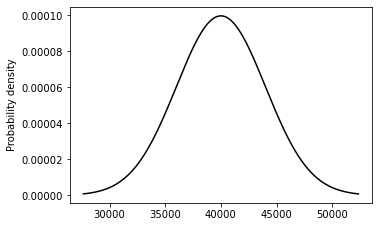

In [4]:
from sim.utils import ScaledDist
ScaledDist(scipy.stats.norm(loc=0, scale=1),
           scipy.stats.norm(loc=40000, scale=4000)).plot()

In [ ]:
from sim.utils import ScaledDist
ScaledDist(scipy.stats.norm(loc=0, scale=1),
           scipy.stats.norm(loc=40000, scale=4000)).plot()

[]

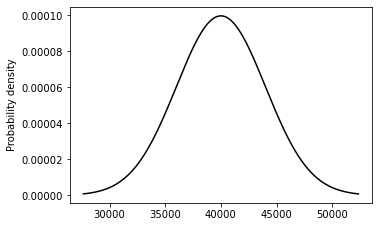

In [12]:
from sim.utils import ScaledDist
ScaledDist(scipy.stats.truncnorm(a=-7, b=np.inf, loc=0, scale=1),
           scipy.stats.truncnorm(a=-7, b=np.inf, loc=40000, scale=4000))  # trunc at 12000

[]

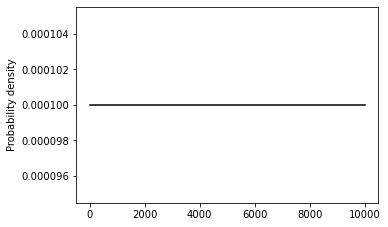

In [5]:
ScaledDist(scipy.stats.uniform(loc=0, scale=1),
            scipy.stats.uniform(loc=0, scale=10000)).plot()


### Run a simulation

In order to run a simulation, the simplest way (which is elfi compatible) is shown below. Note that the square brackets mean that those parameters are lists. The length of these lists should match the `batch_size` parameter, but `batch_size=1` should be fine in general, it just needs to exist to keep elfi happy.

In [2]:
%%time
pod = elfi_sim(
        bottleneck_strength_domestic=[3000],
        bottleneck_strength_wild=[30000],
        bottleneck_time_domestic=[3000],
        bottleneck_time_wild=[4000],
        captive_time=[20],
        div_time=[40000],
        mig_length_post_split=[1000],
        mig_length_wild=[20],
        mig_rate_captive=[0.01],
        mig_rate_post_split=[0.1],
        mig_rate_wild=[0.01],
        pop_size_captive=[1000],
        pop_size_domestic_1=[100],
        pop_size_domestic_2=[100],
        pop_size_wild_1=[500],
        pop_size_wild_2=[500],
        length=int(10e6),
        recombination_rate=1.8e-8,
        mutation_rate=6e-8,
        random_state=np.random.RandomState(3),
        batch_size=1
) 

print(f"pod has shape {pod.shape}")

INFO:root:Param bottleneck_strength_domestic = [3000]
INFO:root:Param bottleneck_strength_wild = [30000]
INFO:root:Param bottleneck_time_domestic = [3000]
INFO:root:Param bottleneck_time_wild = [4000]
INFO:root:Param captive_time = [20]
INFO:root:Param div_time = [40000]
INFO:root:Param mig_length_post_split = [1000]
INFO:root:Param mig_length_wild = [20]
INFO:root:Param mig_rate_captive = [0.01]
INFO:root:Param mig_rate_post_split = [0.1]
INFO:root:Param mig_rate_wild = [0.01]
INFO:root:Param pop_size_captive = [1000]
INFO:root:Param pop_size_domestic_1 = [100]
INFO:root:Param pop_size_domestic_2 = [100]
INFO:root:Param pop_size_wild_1 = [500]
INFO:root:Param pop_size_wild_2 = [500]
INFO:root:Running command: slim -d captive_time=20 -d mig_length_wild=20 -d mig_rate_captive=0.01 -d mig_rate_wild=0.01 -d pop_size_captive=1000 -d pop_size_domestic_1=100 -d pop_size_wild_1=500 -d length=10000000 -d recombination_rate=1.8e-08  -d decap_trees_filename='"../output/decap_218175339.trees"' -s

pod has shape (1, 1)
CPU times: user 1.02 s, sys: 29.4 ms, total: 1.05 s
Wall time: 1.47 s


### Simulation results format

The output is a 1 by 1 numpy matrix. axis 0 corresponds to the batch_size (rows), axis 1 corresponds to simulation outputs (which in our use case is always of shape 1).

In [ ]:
pod = pod[0, 0]  # Get the result out the array

`pod` is an instance of a `GenotypeData` class, which I have defined in model.py. The attributes of the class have things you need for summary statistic calculation. For example, `pod.genotypes["domestic"]` would give you an array of the domestic genotypes. `pod.positions` gives a 1d array of the mutation positions.

In [ ]:
pod.genotypes["all_pops"].shape

Genotypes are given as 3 dimensional, where axis 0 is variants, axis 1 is individuals and axis 2 is ploidy.

### Calculating summary statistics

All the summary statistics can be calculated with:

In [ ]:
summary_stats = elfi_sum(pod)
summary_stats.shape

Again this is two dimensional, in which axis 0 is of size batch_size, and axis 1 is the number of summary statistics. You can have a look through sum_stats.py if you want to calculate specific summary statistics, for example to do a PCA:

In [ ]:
from sim.sum_stats import pca
pod.allelify()  # convert from numpy to scikit allel equivilents
pca_data = pca(pod.genotypes["all_pops"].to_n_alt(), pod.subpops)  # to_n_alt converts to 012 format
sns.scatterplot(pca_data["pc1"], pca_data["pc2"], hue=pca_data["population"])
plt.legend(bbox_to_anchor=(1.05, 1))

If you wish to add more summary statistics, I would suggest adding it as a function in sum_stats.py, which is then called in the `elfi_summary` function.

# Using elfi

### Priors

In elfi, SMC (and bolfi too if you use that), kicks up a fuss if parameters are badly scaled. To overcome this priors are defined using a class ScaledDist (from sim.utils.py).

In [ ]:
from sim.utils import ScaledDist
fake_prior = ScaledDist(sampling=scipy.stats.lognorm(s=0.4, loc=0, scale=1),  # elfi will sample and infer from this distribution
                        target=scipy.stats.lognorm(s=0.4, loc=1, scale=np.exp(2.7)))  # elfi will scale up to this distribution in the simulator

The first distribution doesn't really matter, apart from it should be a standardish scale, and it's shape should match the target distribution so it can be scaled up. The second distribution is our actual prior. This means that the only thing that should change in between the distributions are the `loc` and `scale` parameters. To ensure that scaling works as expected, you can plot the target distribution against a scaled set of samples from the sampling distribution, and check the distributions match:

In [ ]:
fake_prior.plot(show_scaled_kde=True)

Assuming you have already run priors.py you should be able to load the priors with:

In [ ]:
with open ("../output/priors.pkl", "rb") as f:
    priors = pickle.load(f)

In [ ]:
priors["div_time"].plot()

### Real data

The way I got the real data into the same format as the results from the simulations (i.e. an instance of the `GenotypeData` class) is shown below. I thought that although I have done it for the phased data you have given me, in case you want to do it for a different chromosome, or using phasing by a different method, then it may be helpful.

In [ ]:
import allel
from sim.model import GenotypeData
callset = allel.read_vcf("../data/e3_phased.vcf")  #  This is the vcf file you have given me
pop = pd.read_csv("../data/e3_sample_info.csv", usecols=["SOURCE"])["SOURCE"].str.lower().to_numpy().ravel()

subpops = {}
for pop_name in np.unique(pop):
    subpops[pop_name] = np.where(pop == pop_name)[0]

subpops["all_pops"] = np.arange(len(pop))

y_obs = GenotypeData(callset=callset, subpops=subpops, seq_length=44648284)

with open("../data/e3_phased.pkl", "wb") as f:
    pickle.dump(y_obs, f)


Note this will automatically converts the data to biallelic matrices. It also saves the object created using pickle.